In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from scipy.stats import ttest_ind
import math
from scipy.stats import pearsonr, spearmanr
import plotly.graph_objects as go
import plotly.express as px


In [13]:
seed = 42

# load data

In [14]:
meta = pd.read_csv("../data/E0022_P01-P05_sample_map.txt", sep='\t')

In [15]:
meta.shape

(6773, 27)

In [16]:
meta.columns

Index(['Automatic_MS_filename', 'Batch', 'Code', 'Daisy_chain', 'Date',
       'Instrument', 'Replicate', 'Cell_line', 'Cancer_type', 'Tissue_type',
       'SIDM', 'growth_properties', 'MSI_status', 'methylation_data',
       'expression_data', 'cnv_data', 'crispr_ko_data', 'fusion_data',
       'drug_data', 'cancer_type_detail', 'sample_site', 'gender', 'ethnicity',
       'smoking_status', 'BROAD_ID', 'COSMIC_ID', 'CCLE_ID'],
      dtype='object')

In [17]:
meta.head()

Automatic_MS_filename Batch  Code Daisy_chain        Date  \
0  180822_e0022_p02_8078_1_s_m04_1   P02  8078          No  2018-08-22   
1  180822_e0022_p02_8078_2_s_m04_1   P02  8078          No  2018-08-22   
2  180822_e0022_p02_8078_3_s_m04_1   P02  8078          No  2018-08-22   
3  180822_e0022_p02_3090_1_s_m04_1   P02  3090          No  2018-08-22   
4  180822_e0022_p02_3090_2_s_m04_1   P02  3090          No  2018-08-22   

  Instrument  Replicate Cell_line                    Cancer_type  \
0        M04        1.0      BC-1  B-Cell Non-Hodgkin's Lymphoma   
1        M04        2.0      BC-1  B-Cell Non-Hodgkin's Lymphoma   
2        M04        3.0      BC-1  B-Cell Non-Hodgkin's Lymphoma   
3        M04        1.0     L-363            Plasma Cell Myeloma   
4        M04        2.0     L-363            Plasma Cell Myeloma   

                   Tissue_type  ... fusion_data drug_data  \
0  Haematopoietic and Lymphoid  ...        True      True   
1  Haematopoietic and Lymphoid  ...        True      True   
2  Haematopoietic and Lymphoid  ...        True      True   
3  Haematopoietic and Lymphoid  ...        True      True   
4  Haematopoietic and Lymphoid  ...        True      True   

          cancer_type_detail        sample_site  gender ethnicity  \
0  Primary Effusion Lymphoma  Peritoneal Cavity    Male   Unknown   
1  Primary Effusion Lymphoma  Peritoneal Cavity    Male   Unknown   
2  Primary Effusion Lymphoma  Peritoneal Cavity    Male   Unknown   
3        Plasma Cell Myeloma   Peripheral blood  Female   Unknown   
4        Plasma Cell Myeloma   Peripheral blood  Female   Unknown   

  smoking_status    BROAD_ID COSMIC_ID  \
0        Unknown  ACH-002214    910919   
1        Unknown  ACH-002214    910919   
2        Unknown  ACH-002214    910919   
3        Unknown  ACH-000183    924239   
4        Unknown  ACH-000183    924239   

                                   CCLE_ID  
0   BC1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  
1   BC1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  
2   BC1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  
3  L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  
4  L363_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  

[5 rows x 27 columns]

In [18]:
protein_raw = pd.read_csv("../data/protein/E0022_P05_protein_intensities.txt", sep='\t')

In [19]:
protein_raw.shape

(6773, 3945)

In [20]:
ic50 = pd.read_csv(
    "../data/drug/DrugResponse_PANCANCER_GDSC1_GDSC2_IC_20191119.csv")
ic50 = ic50.sort_values(by=['Dataset version'])
ic50 = ic50.drop_duplicates(
    ['Drug Id', 'Cell line name'], keep='last').sort_values(
        by=['Drug Id', 'Cell line name']).reset_index(drop=True)

### ??Max conc? max concentration?

### ??what exactly is this IC50? is it normalised across different drugs?

In [149]:
ic50.head(3)

Drug name  Drug Id Cell line name  Cosmic sample Id TCGA classification  \
0  Erlotinib        1         MC-CAR            683665                  MM   
1  Erlotinib        1            ES3            684055        UNCLASSIFIED   
2  Erlotinib        1            ES5            684057        UNCLASSIFIED   

  Tissue                Tissue sub-type      IC50       AUC  Max conc  \
0  blood  haematopoietic_neoplasm_other  2.395685  0.982114       2.0   
1   bone                 ewings_sarcoma  3.140923  0.984816       2.0   
2   bone                 ewings_sarcoma  3.968757  0.985693       2.0   

       RMSE   Z score Dataset version  
0  0.022521 -0.189576           GDSC1  
1  0.031840  0.508635           GDSC1  
2  0.026052  1.284229           GDSC1

# Protein avg

### ?? Code is the Key?

### ?? need to worry about batch effect?

In [11]:
protein_raw = protein_raw.rename(columns={'Unnamed: 0': 'Automatic_MS_filename'})
protein_raw_merge = pd.merge(protein_raw, meta[['Automatic_MS_filename', 'Cell_line']])

protein_sample_avg = protein_raw_merge.drop(['Automatic_MS_filename'],
                                            axis=1).groupby(['Cell_line']).agg(np.nanmean).reset_index()

In [458]:
df = protein_raw_merge[protein_raw_merge['Cell_line']=='201T']
pd.options.display.max_columns = None
display(df)

Automatic_MS_filename  1433B_HUMAN  1433E_HUMAN  \
4666  191005_b43-t1-13_00dlf_00jcq_m01_s_1    -0.139640    -1.010060   
4698  191006_b45-t1-13_00dmb_00jd7_m01_s_1    -0.594430    -1.068399   
4749  191008_b45-t2-13_00dmb_00jep_m03_s_1    -0.183301    -0.690751   
4762  191008_b47-t1-13_00dn7_00jfo_m01_s_1     0.156158    -0.422248   
4781  191009_b43-t2-13_00dlf_00jg8_m03_s_1    -0.026275    -0.656359   
5131  191017_b47-t3-13_00dn7_00kak_m04_s_1    -0.323651    -0.914798   

      1433F_HUMAN  1433G_HUMAN  1433S_HUMAN  1433T_HUMAN  1433Z_HUMAN  \
4666    -1.308042     0.302148     2.502514    -0.559641    -0.076059   
4698    -1.463917     0.076590     2.395107    -0.772315    -0.309909   
4749    -0.975621     0.240156     2.284636    -0.308232    -0.021773   
4762    -0.799070    -0.164187     2.475982    -0.487009    -0.154793   
4781    -0.857373     0.282256     2.344112    -0.323152     0.062130   
5131    -1.108968    -0.241625     2.653054    -0.630448    -0.458008   

      1A03_HUMAN  1A24_HUMAN  2A5D_HUMAN  2A5E_HUMAN  2AAA_HUMAN  2AAB_HUMAN  \
4666         NaN         NaN    0.083579   -0.872072   -0.154319   -0.835646   
4698         NaN         NaN    0.211445   -0.475008   -0.389563   -0.698498   
4749         NaN         NaN    0.192678   -0.687058   -0.264791   -0.698498   
4762         NaN         NaN    0.138787   -0.502499   -0.382180   -0.698498   
4781         NaN         NaN    0.071295   -0.201743   -0.218772   -0.561349   
5131         NaN   -5.418205    0.134937   -0.276616   -0.349952   -0.698498   

      2ABA_HUMAN  2B19_HUMAN  3HIDH_HUMAN  3MG_HUMAN  41_HUMAN  4ET_HUMAN  \
4666         NaN         NaN     0.666342  -0.959729 -1.418250        NaN   
4698    1.292928         NaN     0.530348  -0.557875 -1.423662        NaN   
4749         NaN         NaN     0.679941  -0.502390 -1.412838        NaN   
4762         NaN         NaN     0.378405  -0.176788 -1.418250        NaN   
4781         NaN         NaN     0.820258  -0.166237 -1.344157        NaN   
5131         NaN   -0.688856     0.596635  -0.015457 -1.418250        NaN   

      4F2_HUMAN  5NT3A_HUMAN  5NTD_HUMAN  6PGD_HUMAN  6PGL_HUMAN  7B2_HUMAN  \
4666   1.897295     0.028083   -1.304440    3.512027    0.198786        NaN   
4698   1.824489     0.178106   -1.019927    3.052286    0.259993        NaN   
4749   2.056734     0.116426   -1.211094    3.311365    0.228288        NaN   
4762   1.942068     0.090447   -1.122418    3.427118    0.559269        NaN   
4781   1.979963     0.169068   -1.103709    3.603034    0.186873   -2.15617   
5131   1.625768     0.116426   -1.369569    3.036173    0.390795        NaN   

      8ODP_HUMAN  A16A1_HUMAN  A2MG_HUMAN  A4_HUMAN  AAAS_HUMAN  AAAT_HUMAN  \
4666         NaN    -0.408213    1.695673 -0.157531   -0.151436    0.229705   
4698         NaN    -0.291245    1.134223  0.107665    0.045524    0.492888   
4749         NaN    -0.224748    2.333896  0.185536    0.139075    0.426049   
4762         NaN    -0.073424    1.363658 -0.145027    0.006022    0.394249   
4781         NaN    -0.224748    1.950914  0.326040   -0.111376    0.457222   
5131   -0.647966    -0.095158    1.695673  0.201445   -0.390122    0.435891   

      AAGAB_HUMAN  AAK1_HUMAN  AAMDC_HUMAN  AAPK1_HUMAN  AASD1_HUMAN  \
4666    -0.378939   -1.164258          NaN     0.904806    -0.523536   
4698     0.719687   -0.930318          NaN     0.822934    -0.486365   
4749     0.353481   -0.930318          NaN     0.740886    -0.801768   
4762     0.468214   -0.744049          NaN     1.240226    -0.081959   
4781    -0.098493   -0.882645          NaN     0.725033    -0.624393   
5131     0.206197   -0.930318          NaN     1.126803    -0.375616   

      AASS_HUMAN  AATC_HUMAN  AATF_HUMAN  AATM_HUMAN  AB1IP_HUMAN  \
4666         NaN    0.365660    0.273084   -0.352503     0.300049   
4698         NaN    0.513278    0.330150   -0.323432     0.300049   
4749         NaN    0.611222    0.299211   -0.135506     0.579299   
4762         N

In [67]:
protein_sample_avg.shape

(957, 3945)

In [47]:
protein_per = []
for col in range(1, protein_raw.shape[1]):
    protein_per.append(1 - (np.sum(np.isnan(protein_raw.iloc[:, col])) /
                            (protein_raw.shape[0])))
protein_per = np.array(protein_per)

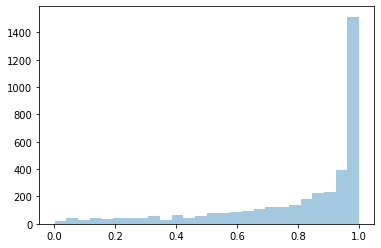

In [48]:
sns.distplot(protein_per, kde=False)

In [51]:
protein_per_cagetory = {'fraction_of_samples': [], 'protein_count':[]}
for p in [0.01, 0.25, 0.5, 0.75, 1]:
    protein_per_cagetory['fraction_of_samples'].append(f'{p:.0%}')
    protein_per_cagetory['protein_count'].append(np.sum(protein_per>=p))
protein_per_cagetory_df = pd.DataFrame(protein_per_cagetory)

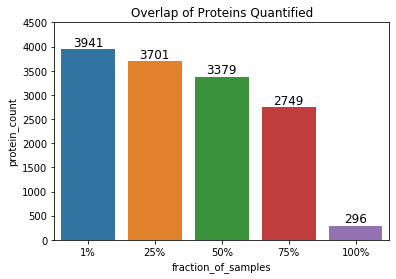

In [52]:
# Rounding the integer to the next hundredth value plus an offset of 100
def roundup(x):
    return 500 + int(math.ceil(x / 100.0)) * 100 

sns.barplot(x='fraction_of_samples', y='protein_count', data=protein_per_cagetory_df)
plt.title("Overlap of Proteins Quantified")
ax = plt.gca()

# ylim max value to be set
y_max = protein_per_cagetory_df['protein_count'].max() 
ax.set_ylim([0, roundup(y_max)])

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()

# IC 50 EDA

### ??one drug name -> multiple drug id?

In [148]:
ic50_count = ic50.groupby(['Cell line name',
                           'Drug name']).size().reset_index(name='num_IC50')

ic50_count.groupby(['num_IC50']).size()

num_IC50
1    277811
2     48024
3      3951
dtype: int64

In [51]:
ic50_count[ic50_count['num_IC50']==3].head(3)

Cell line name  Drug name  num_IC50
266          22RV1   Afatinib         3
332          22RV1  Docetaxel         3
456          22RV1   Olaparib         3

In [54]:
ic50[(ic50['Cell line name']=='201T') & (ic50['Drug name']=='AKT inhibitor VIII')]

Drug name  Drug Id Cell line name  Cosmic sample Id  \
36469  AKT inhibitor VIII      171           201T           1287381   
69392  AKT inhibitor VIII      228           201T           1287381   

      TCGA classification Tissue            Tissue sub-type      IC50  \
36469                LUAD   lung  lung_NSCLC_adenocarcinoma  0.682822   
69392                LUAD   lung  lung_NSCLC_adenocarcinoma  0.877638   

            AUC  Max conc      RMSE   Z score Dataset version  
36469  0.826997      2.56  0.127079 -1.618192           GDSC1  
69392  0.688381     10.24  0.030763 -1.184675           GDSC1

In [52]:
ic50[(ic50['Cell line name']=='22RV1') & (ic50['Drug name']=='Afatinib')]

Drug name  Drug Id Cell line name  Cosmic sample Id  \
204222  Afatinib     1032          22RV1            924100   
259062  Afatinib     1377          22RV1            924100   
276397  Afatinib     1032          22RV1            924100   

       TCGA classification             Tissue Tissue sub-type      IC50  \
204222                PRAD  urogenital_system        prostate  2.117726   
259062                PRAD  urogenital_system        prostate  3.997181   
276397                PRAD  urogenital_system        prostate  2.433064   

             AUC  Max conc      RMSE   Z score Dataset version  
204222  0.981536       0.5  0.075250  0.890461           GDSC1  
259062  0.955315      10.0  0.019411  0.363240           GDSC1  
276397  0.879934      10.0  0.084471  0.502790           GDSC2

In [46]:
ic50[(ic50['Cell line name']=='GMS-10') & (ic50['Drug name']=='PLX-4720')]

Drug name  Drug Id Cell line name  Cosmic sample Id  \
205800  PLX-4720     1036         GMS-10            906873   
255165  PLX-4720     1371         GMS-10            906873   
276916  PLX-4720     1036         GMS-10            906873   

       TCGA classification          Tissue Tissue sub-type      IC50  \
205800                 GBM  nervous_system          glioma  3.574601   
255165                 GBM  nervous_system          glioma  3.889073   
276916                 GBM  nervous_system          glioma  2.587135   

             AUC  Max conc      RMSE   Z score Dataset version  
205800  0.958029      10.0  0.030193 -0.045636           GDSC1  
255165  0.968635      10.0  0.040881 -0.170848           GDSC1  
276916  0.911833      10.0  0.057616 -1.077039           GDSC2

In [48]:
ic50['Drug Id'].unique().shape

(453,)

In [47]:
ic50['Drug name'].unique().shape

(397,)

### ?? some drugs only have a few cell lines?

Text(0, 0.5, 'Number of drugs')

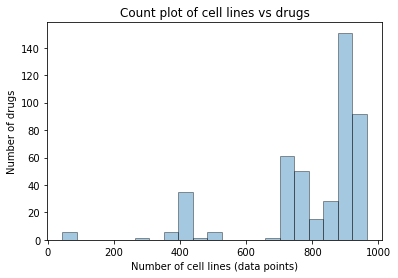

In [341]:
sns.distplot(ic50.drop_duplicates(['Drug Id', 'Cell line name'
                                   ]).groupby(['Drug Id'
                                               ]).size().sort_values(),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title('Count plot of cell lines vs drugs')
plt.xlabel("Number of cell lines (data points)")
plt.ylabel("Number of drugs")

## version investigation

### ?? any pattern/difference at all for why we do some twice?

In [11]:
ic50_count_id = ic50.groupby(['Cell line name', 'Drug Id']).size().reset_index(name='num_IC50')

ic50_multiple = pd.merge(ic50,
                         ic50_count_id,
                         on=['Cell line name', 'Drug Id'],
                         how='inner')
ic50_multiple = ic50_multiple.drop_duplicates(subset=['Cell line name', 'Drug Id', 'num_IC50'])

In [52]:
ic50_multiple.to_csv("../data/ic50_multiple.tsv", sep='\t', index=False)

In [57]:
ic50_multiple[ic50_multiple['num_IC50'] > 1].sort_values(
    by=['Drug Id', 'Cell line name']).head(5)

Drug name  Drug Id Cell line name  Cosmic sample Id  \
179374  Vinblastine     1004          22RV1            924100   
179336  Vinblastine     1004       23132-87            910924   
178314  Vinblastine     1004       42-MG-BA            687561   
178699  Vinblastine     1004          639-V            906798   
178697  Vinblastine     1004          647-V            906797   

       TCGA classification             Tissue Tissue sub-type      IC50  \
179374                PRAD  urogenital_system        prostate -4.388236   
179336                STAD   digestive_system         stomach -4.570881   
178314                 GBM     nervous_system          glioma -4.640557   
178699                BLCA  urogenital_system         bladder -5.210726   
178697                BLCA  urogenital_system         bladder -3.838899   

             AUC  Max conc      RMSE   Z score Dataset version  num_IC50  
179374  0.601501       0.1  0.088278 -0.183661           GDSC1         2  
179336  0.580232       0.1  0.148553 -0.312862           GDSC1         2  
178314  0.568245       0.1  0.091034 -0.362151           GDSC1         2  
178699  0.477119       0.1  0.098459 -0.765481           GDSC1         2  
178697  0.688018       0.1  0.109111  0.204933           GDSC1         2

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text xticklabel objects>)

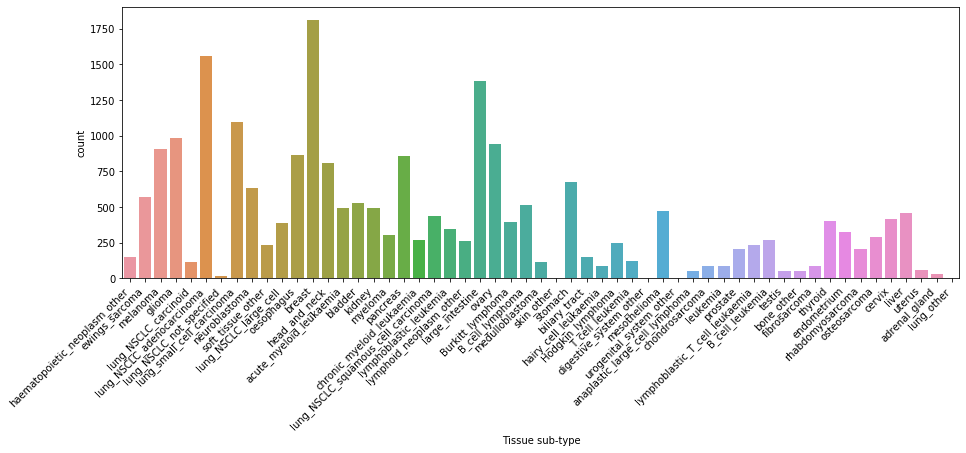

In [77]:
plt.figure(figsize=(15,5))
sns.countplot('Tissue sub-type',
              data=ic50_multiple[ic50_multiple['num_IC50'] > 1],
              order=ic50_multiple['Tissue sub-type'].unique())
plt.xticks(rotation=45, ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text xticklabel objects>)

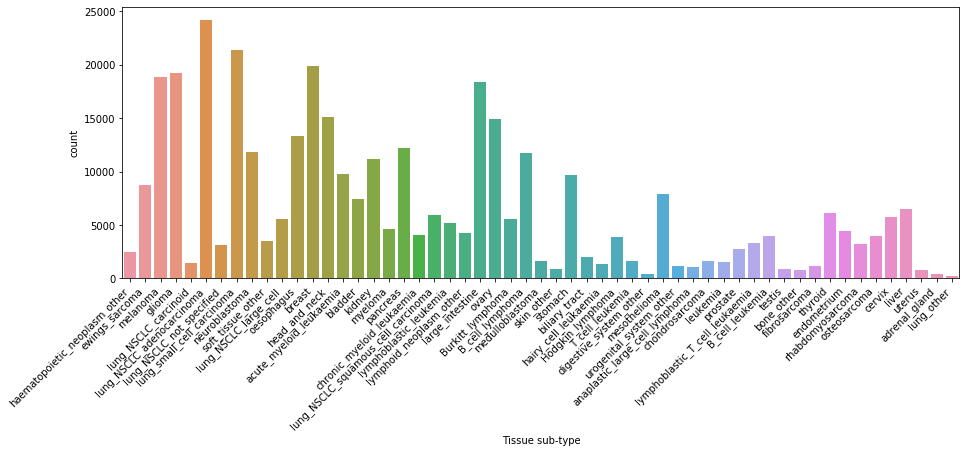

In [78]:
plt.figure(figsize=(15, 5))
sns.countplot('Tissue sub-type',
              data=ic50_multiple,
              order=ic50_multiple['Tissue sub-type'].unique())
plt.xticks(rotation=45, ha='right')

In [25]:
ic50_multiple_withdup = pd.merge(ic50,
                                 ic50_count_id,
                                 on=['Cell line name', 'Drug Id'],
                                 how='inner')
ttest_ind(
    ic50_multiple_withdup[(ic50_multiple_withdup['num_IC50'] > 1)
                          & (ic50_multiple_withdup['Dataset version'] == 'GDSC1')]
    ['IC50'].values, ic50_multiple_withdup[
        (ic50_multiple_withdup['num_IC50'] > 1)
        & (ic50_multiple_withdup['Dataset version'] == 'GDSC2')]['IC50'].values)

Ttest_indResult(statistic=-28.26754980310574, pvalue=2.8702090040731375e-174)

In [26]:
ic50_multiple_withdup[
    (ic50_multiple_withdup['num_IC50'] > 1)
    & (ic50_multiple_withdup['Dataset version'] == 'GDSC1')]['IC50'].mean()

1.3716498106029786

In [27]:
ic50_multiple_withdup[
    (ic50_multiple_withdup['num_IC50'] > 1)
    & (ic50_multiple_withdup['Dataset version'] == 'GDSC2')]['IC50'].mean()

2.1333658606721952

Text(0.5, 0.98, 'IC50 distribution for GDSC1 and GDSC2')

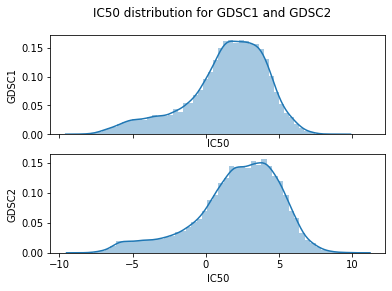

In [79]:
fig, ax = plt.subplots(2,1, sharex=True)
sns.distplot(ic50_multiple_withdup[
    (ic50_multiple_withdup['num_IC50'] > 1)
    & (ic50_multiple_withdup['Dataset version'] == 'GDSC1')]['IC50'],ax=ax[0])
sns.distplot(ic50_multiple_withdup[
    (ic50_multiple_withdup['num_IC50'] > 1)
    & (ic50_multiple_withdup['Dataset version'] == 'GDSC2')]['IC50'],ax=ax[1])
ax[0].set_ylabel('GDSC1')
ax[1].set_ylabel('GDSC2')
fig.suptitle("IC50 distribution for GDSC1 and GDSC2")

should be safe to just pick any one

## which drug is generally more effective 

In [249]:
ic50.groupby(['Drug Id'])['IC50'].mean().sort_values()

Drug Id
104    -5.594471
201    -4.923461
1911   -4.723186
1191   -4.722578
1007   -4.687203
1494   -4.162053
1941   -4.081928
180    -3.890701
140    -3.831378
1004   -3.804956
268    -3.728268
461    -3.164380
1248   -3.075851
11     -3.035452
1031   -3.017415
438    -3.003480
474    -2.994047
2048   -2.914303
194    -2.909762
197    -2.898588
283    -2.887536
200    -2.777120
1080   -2.579103
1180   -2.529664
1811   -2.501808
87     -2.429703
135    -2.343893
3      -2.252423
1084   -2.238188
1003   -2.231096
          ...   
147     4.901155
2043    4.902135
1925    4.922179
1927    4.933403
231     4.968548
1578    4.982337
1615    5.042620
2107    5.095685
236     5.113065
1635    5.139387
1852    5.142808
1237    5.171542
427     5.181830
1512    5.194712
447     5.248090
1620    5.256052
193     5.281657
415     5.295271
1931    5.345380
341     5.386697
266     5.470953
1563    5.573161
409     5.580156
1375    5.717880
1814    5.911200
1114    5.985968
1807    6.112940
165   

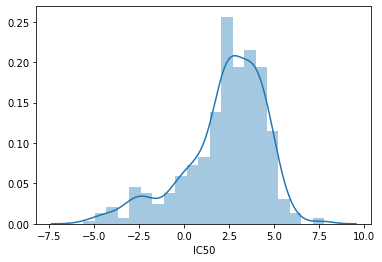

In [254]:
sns.distplot(ic50.groupby(['Drug Id'])['IC50'].mean())

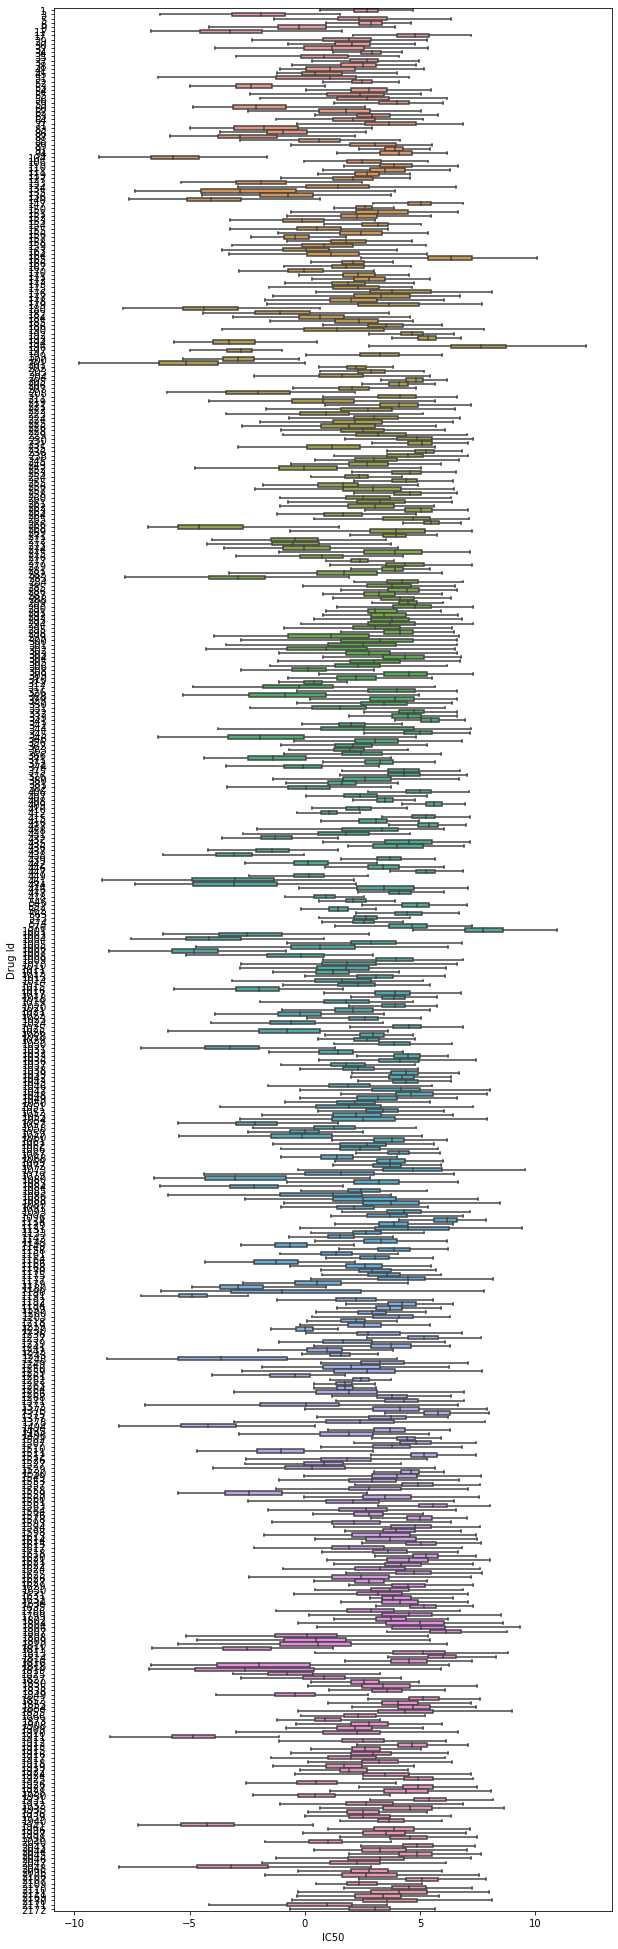

In [246]:
plt.figure(figsize=(10, 35))
sns.boxplot(x='IC50', y='Drug Id', data=ic50, orient='h', showfliers=False)

In [252]:
ic50[ic50['Drug Id']==104]

Drug name  Drug Id Cell line name  Cosmic sample Id  \
13913  Bortezomib      104         MC-CAR            683665   
13914  Bortezomib      104            ES3            684055   
13915  Bortezomib      104            ES5            684057   
13916  Bortezomib      104          EW-11            684062   
13917  Bortezomib      104        SK-ES-1            684072   
13918  Bortezomib      104       COLO-829            687448   
13919  Bortezomib      104        8-MG-BA            687562   
13920  Bortezomib      104           GB-1            687568   
13921  Bortezomib      104        U-87-MG            687590   
13922  Bortezomib      104       NCI-H720            687600   
13923  Bortezomib      104      NCI-H1648            687799   
13924  Bortezomib      104      NCI-H1770            687804   
13925  Bortezomib      104      NCI-H1838            687807   
13926  Bortezomib      104        DMS-114            687983   
13927  Bortezomib      104      NCI-H1092            687997   
13928  Bortezomib      104      NCI-H1417            688001   
13929  Bortezomib      104      NCI-H1694            688006   
13930  Bortezomib      104       NCI-H187            688007   
13931  Bortezomib      104      NCI-H1963            688010   
13932  Bortezomib      104       NCI-H209            688013   
13933  Bortezomib      104      NCI-H2141            688014   
13934  Bortezomib      104      NCI-H2171            688015   
13935  Bortezomib      104      NCI-H2227            688018   
13936  Bortezomib      104       NCI-H345            688021   
13937  Bortezomib      104       NCI-H446            688023   
13938  Bortezomib      104       NCI-H526            688025   
13939  Bortezomib      104        NCI-H64            688026   
13940  Bortezomib      104        NCI-H69            688027   
13941  Bortezomib      104        NCI-H82            688031   
13942  Bortezomib      104        SK-N-DZ            688086   
...           ...      ...            ...               ...   
14276  Bortezomib      104       JURL-MK1           1327771   
14277  Bortezomib      104     KARPAS-231           1327774   
14278  Bortezomib      104         KCL-22           1330931   
14279  Bortezomib      104         KOPN-8           1330933   
14280  Bortezomib      104         L-1236           1330935   
14281  Bortezomib      104           ME-1           1330942   
14282  Bortezomib      104        MOLM-13           1330947   
14283  Bortezomib      104         MOLP-8           1330950   
14284  Bortezomib      104         MY-M12           1330960   
14285  Bortezomib      104      NCI-H1876           1330972   
14286  Bortezomib      104        NK-92MI           1330981   
14287  Bortezomib      104       NU-DUL-1           1330982   
14288  Bortezomib      104       OCI-AML5           1330983   
14289  Bortezomib      104      OCI-LY-19           1330984   
14290  Bortezomib      104         OCI-M1           1330985   
14291  Bortezomib      104        P32-ISH           1330987   
14292  Bortezomib      104          PL-21           1330991   
14293  Bortezomib      104          RC-K8           1330995   
14294  Bortezomib      104         ROS-50           1331025   
14295  Bortezomib      104           SLVL           1331032   
14296  Bortezomib      104      SU-DHL-16           1331034   
14297  Bortezomib      104       SU-DHL-4           1331035   
14298  Bortezomib      104       SU-DHL-6           1331037   
14299  Bortezomib      104       SU-DHL-8           1331038   
14300  Bortezomib      104        SUP-HD1           1331039   
14301  Bortezomib      104         SUP-M2           1331040   
14302  Bortezomib      104             TK           1331045   
14303  Bortezomib      104            VAL           1331048   
14304  Bortezomib      104        WIL2-NS           1331049   
14305  Bortezomib      104      WSU-DLCL2           1331050   

      TCGA classification          Tissue                 Tissue sub-type  \
13913                  M

In [251]:
ic50[ic50['Drug Id']==1001]

Drug name  Drug Id Cell line name  Cosmic sample Id  \
177346  AICA Ribonucleotide     1001         MC-CAR            683665   
177347  AICA Ribonucleotide     1001         PFSK-1            683667   
177348  AICA Ribonucleotide     1001           A673            684052   
177349  AICA Ribonucleotide     1001            ES3            684055   
177350  AICA Ribonucleotide     1001            ES5            684057   
177351  AICA Ribonucleotide     1001            ES7            684059   
177352  AICA Ribonucleotide     1001          EW-11            684062   
177353  AICA Ribonucleotide     1001        SK-ES-1            684072   
177354  AICA Ribonucleotide     1001       COLO-829            687448   
177355  AICA Ribonucleotide     1001           5637            687452   
177356  AICA Ribonucleotide     1001            RT4            687455   
177357  AICA Ribonucleotide     1001          SW780            687457   
177358  AICA Ribonucleotide     1001         TCCSUP            687459   
177359  AICA Ribonucleotide     1001         C-33-A            687505   
177360  AICA Ribonucleotide     1001          C-4-I            687506   
177361  AICA Ribonucleotide     1001         ME-180            687514   
177362  AICA Ribonucleotide     1001       42-MG-BA            687561   
177363  AICA Ribonucleotide     1001        8-MG-BA            687562   
177364  AICA Ribonucleotide     1001           A172            687563   
177365  AICA Ribonucleotide     1001           GB-1            687568   
177366  AICA Ribonucleotide     1001           T98G            687586   
177367  AICA Ribonucleotide     1001       U-118-MG            687588   
177368  AICA Ribonucleotide     1001        U-87-MG            687590   
177369  AICA Ribonucleotide     1001          YKG-1            687592   
177370  AICA Ribonucleotide     1001      ChaGo-K-1            687596   
177371  AICA Ribonucleotide     1001       NCI-H720            687600   
177372  AICA Ribonucleotide     1001         Calu-3            687777   
177373  AICA Ribonucleotide     1001        COR-L23            687780   
177374  AICA Ribonucleotide     1001           LK-2            687787   
177375  AICA Ribonucleotide     1001      NCI-H1437            687794   
...                     ...      ...            ...               ...   
178255  AICA Ribonucleotide     1001         OVK-18           1480371   
178256  AICA Ribonucleotide     1001           PEO1           1480372   
178257  AICA Ribonucleotide     1001       UWB1.289           1480374   
178258  AICA Ribonucleotide     1001          FLO-1           1503361   
178259  AICA Ribonucleotide     1001         OACp4C           1503362   
178260  AICA Ribonucleotide     1001        OACM5-1           1503363   
178261  AICA Ribonucleotide     1001        SK-GT-2           1503364   
178262  AICA Ribonucleotide     1001        SK-GT-4           1503365   
178263  AICA Ribonucleotide     1001          ESO26           1503366   
178264  AICA Ribonucleotide     1001          ESO51           1503367   
178265  AICA Ribonucleotide     1001         KYAE-1           1503368   
178266  AICA Ribonucleotide     1001      EMC-BAC-1           1503369   
178267  AICA Ribonucleotide     1001      EMC-BAC-2           1503370   
178268  AICA Ribonucleotide     1001           TE-4           1503371   
178269  AICA Ribonucleotide     1001         NCC010           1509073   
178270  AICA Ribonucleotide     1001         NCC021           1509074   
178271  AICA Ribonucleotide     1001        RCC-FG2           1524414   
178272  AICA Ribonucleotide     1001         RCC-JF           1524415   
178273  AICA Ribonucleotide     1001         RCC-JW           1524416   
178274  AICA Ribonucleotide     1001         RCC-ER           1524417   
178275  AICA Ribonucleotide     1001         RCC-AB           1524418   
178276  AICA Ribonucleotide     1001         RCC-MF           1524419   
178277  AICA Ribonucleotide     1001         KMS-11           1659817   
178

## performance analysis

### ??shouldn't we have one AUC/RMSE per drug only?

In [99]:
ic50.head()

Drug name  Drug Id Cell line name  Cosmic sample Id TCGA classification  \
0  Erlotinib        1         MC-CAR            683665                  MM   
1  Erlotinib        1            ES3            684055        UNCLASSIFIED   
2  Erlotinib        1            ES5            684057        UNCLASSIFIED   
3  Erlotinib        1            ES7            684059        UNCLASSIFIED   
4  Erlotinib        1          EW-11            684062        UNCLASSIFIED   

  Tissue                Tissue sub-type      IC50       AUC  Max conc  \
0  blood  haematopoietic_neoplasm_other  2.395685  0.982114       2.0   
1   bone                 ewings_sarcoma  3.140923  0.984816       2.0   
2   bone                 ewings_sarcoma  3.968757  0.985693       2.0   
3   bone                 ewings_sarcoma  2.692768  0.972699       2.0   
4   bone                 ewings_sarcoma  2.478678  0.944462       2.0   

       RMSE   Z score Dataset version  
0  0.022521 -0.189576           GDSC1  
1  0.031840  0.508635           GDSC1  
2  0.026052  1.284229           GDSC1  
3  0.110056  0.088760           GDSC1  
4  0.087011 -0.111820           GDSC1

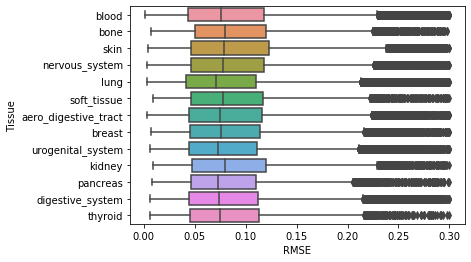

In [85]:
sns.boxplot(x='RMSE', y='Tissue', data=ic50, orient='h')

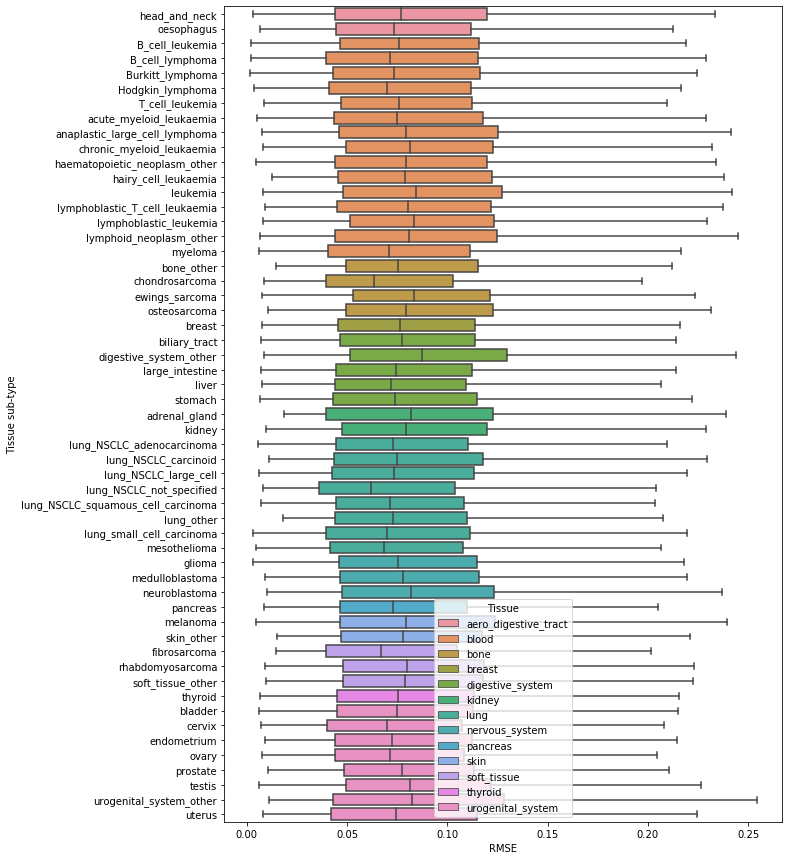

In [84]:
plt.figure(figsize=(10, 15))
sns.boxplot(x='RMSE',
            y='Tissue sub-type',
            data=ic50,
            orient='h',
            hue='Tissue',
            order=ic50.sort_values(by=['Tissue','Tissue sub-type'])['Tissue sub-type'].unique(),
            hue_order=ic50.sort_values(by=['Tissue','Tissue sub-type'])['Tissue'].unique(),
            showfliers=False,
            dodge=False)

## drug id vs name

In [98]:
ic50['Drug name'].unique().size

397

In [96]:
ic50['Drug Id'].unique().size

453

In [54]:
ic50_us = ic50[(ic50['Drug Id'] < 1000)].drop(['Dataset version'], axis=1).drop_duplicates()
ic50_uk = ic50[(ic50['Drug Id'] > 1000)].drop(['Dataset version'], axis=1).drop_duplicates()

In [55]:
ic50_overlap = pd.merge(ic50_us, ic50_uk, on=['Drug name', 'Cell line name'], how='inner')

In [56]:
ic50_overlap

Drug name  Drug Id_x Cell line name  Cosmic sample Id_x  \
0      Erlotinib          1         MC-CAR              683665   
1      Erlotinib          1            ES7              684059   
2      Erlotinib          1          EW-11              684062   
3      Erlotinib          1        SK-ES-1              684072   
4      Erlotinib          1       COLO-829              687448   
5      Erlotinib          1        8-MG-BA              687562   
6      Erlotinib          1           GB-1              687568   
7      Erlotinib          1        U-87-MG              687590   
8      Erlotinib          1       NCI-H720              687600   
9      Erlotinib          1      NCI-H1648              687799   
10     Erlotinib          1      NCI-H1838              687807   
11     Erlotinib          1        DMS-114              687983   
12     Erlotinib          1      NCI-H1092              687997   
13     Erlotinib          1      NCI-H1417              688001   
14     Erlotinib          1      NCI-H1694              688006   
15     Erlotinib          1      NCI-H1963              688010   
16     Erlotinib          1       NCI-H209              688013   
17     Erlotinib          1      NCI-H2141              688014   
18     Erlotinib          1       NCI-H446              688023   
19     Erlotinib          1       NCI-H526              688025   
20     Erlotinib          1        NCI-H64              688026   
21     Erlotinib          1        NCI-H69              688027   
22     Erlotinib          1        NCI-H82              688031   
23     Erlotinib          1        SK-N-DZ              688086   
24     Erlotinib          1        SK-N-FI              688087   
25     Erlotinib          1       VA-ES-BJ              688121   
26     Erlotinib          1         Calu-6              724859   
27     Erlotinib          1          LU-65              724863   
28     Erlotinib          1      NCI-H1355              724866   
29     Erlotinib          1         SHP-77              724872   
...          ...        ...            ...                 ...   
23269    Wnt-C59        574      SU-DHL-10             1331033   
23270    Wnt-C59        574       SU-DHL-5             1331036   
23271    Wnt-C59        574       SU-DHL-6             1331037   
23272    Wnt-C59        574       SU-DHL-8             1331038   
23273    Wnt-C59        574        SUP-HD1             1331039   
23274    Wnt-C59        574         SUP-M2             1331040   
23275    Wnt-C59        574             TK             1331045   
23276    Wnt-C59        574            VAL             1331048   
23277    Wnt-C59        574        WIL2-NS             1331049   
23278    Wnt-C59        574          DOV13             1479987   
23279    Wnt-C59        574            Hey             1479988   
23280    Wnt-C59        574          OV-56             1480362   
23281    Wnt-C59        574        OVCA420             1480364   
23282    Wnt-C59        574         OVK-18             1480371   
23283    Wnt-C59        574           PEO1             1480372   
23284    Wnt-C59        574          FLO-1             1503361   
23285    Wnt-C59        574         OACp4C             1503362   
23286    Wnt-C59        574        OACM5-1             1503363   
23287    Wnt-C59        574        SK-GT-4             1503365   
23288    Wnt-C59        574          ESO26             1503366   
23289    Wnt-C59        574         KYAE-1             1503368   
23290    Wnt-C59        574      EMC-BAC-2             1503370   
23291    Wnt-C59        574           TE-4             1503371   
23292    Wnt-C59        574         RCC-JW             1524416   
23293    Wnt-C59        574       SNU-1040             1659823   
23294    Wnt-C59        574        SNU-175             1659928   
23295    Wnt-C59        574        SNU-407             1660034   
23296    Wnt-C59        574         SNU-61             1660035   
23297    Wnt-C59        574         SNU-81     

Text(0.5, 0, 'Delta IC50')

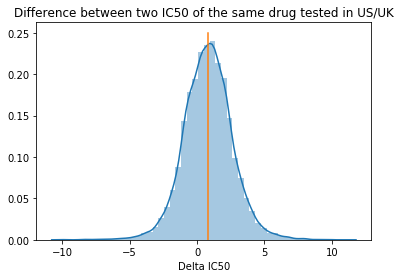

In [59]:
sns.distplot(ic50_overlap['IC50_y'] - ic50_overlap['IC50_x'])
plt.plot((np.mean(ic50_overlap['IC50_y'] - ic50_overlap['IC50_x']), np.mean(ic50_overlap['IC50_y'] - ic50_overlap['IC50_x'])),
         (0, 0.25))
plt.title("Difference between two IC50 of the same drug tested in US/UK")
plt.xlabel("Delta IC50")

In [95]:
print(ic50_overlap['Drug name'].unique().size)
print(np.abs(ic50_overlap['IC50_y'] - ic50_overlap['IC50_x']).mean())

41
1.5440608687532336


In [92]:
print(ic50_overlap['Drug Id_y'].unique().size)

43


In [109]:
ic50_name_id = ic50.drop_duplicates(subset=['Drug Id', 'Drug name']).groupby(['Drug name']).size().sort_values()

In [111]:
ic50_name_id[ic50_name_id>1].index

Index(['MIM1', 'Entinostat', 'Ruxolitinib', 'Paclitaxel', 'Rapamycin',
       'Refametinib', 'Sorafenib', 'Wnt-C59', 'Linsitinib', 'Crizotinib',
       'Lapatinib', 'AKT inhibitor VIII', 'AGI-6780', 'LGK974', 'Dactinomycin',
       'LCL161', 'Pictilisib', 'Dasatinib', '5-Fluorouracil', 'Luminespib',
       'Vinorelbine', 'VX-11e', 'SB505124', 'Olaparib', 'Obatoclax Mesylate',
       'Bortezomib', 'GSK1904529A', 'Bicalutamide', 'OSI-027', 'Fulvestrant',
       'GSK269962A', 'Sepantronium bromide', 'Selumetinib', 'BMS-754807',
       'BMS-536924', 'Foretinib', 'Docetaxel', 'Ulixertinib', 'PLX-4720',
       'I-BET-762', 'Oxaliplatin', 'Afatinib', 'Erlotinib', 'Uprosertib',
       'BI-2536', 'BMS-345541', 'UNC0638', 'Gemcitabine', 'Avagacestat',
       'Tozasertib', 'CHIR-99021', 'Alisertib', 'JQ1', 'AZD6482'],
      dtype='object', name='Drug name')

In [112]:
ic50_drugidname = ic50.drop_duplicates(subset=['Drug Id', 'Drug name'])

In [117]:
ic50_drugidname[ic50_drugidname['Drug name'].isin(
    ic50_name_id[ic50_name_id > 1].index)].sort_values(by=['Drug name'])

Drug name  Drug Id Cell line name  Cosmic sample Id  \
41844         5-Fluorouracil      179         MC-CAR            683665   
286092        5-Fluorouracil     1073         MC-CAR            683665   
332957              AGI-6780     1634         MC-CAR            683665   
172780              AGI-6780      562         MC-CAR            683665   
35715     AKT inhibitor VIII      171         MC-CAR            683665   
68641     AKT inhibitor VIII      228         MC-CAR            683665   
223982               AZD6482     1066         MC-CAR            683665   
384825               AZD6482     2169        HCC1954            749709   
26900                AZD6482      156         MC-CAR            683665   
258483              Afatinib     1377         MC-CAR            683665   
203624              Afatinib     1032         MC-CAR            683665   
280626             Alisertib     1051         MC-CAR            683665   
156400             Alisertib      431         MC-CAR            683665   
226775           Avagacestat     1072         MC-CAR            683665   
57712            Avagacestat      205         MC-CAR            683665   
9146                 BI-2536       60         MC-CAR            683665   
290654               BI-2536     1086        HCC1954            749709   
302720            BMS-345541     1249         MC-CAR            683665   
55912             BMS-345541      203         MC-CAR            683665   
9543              BMS-536924       62         MC-CAR            683665   
227716            BMS-536924     1091         MC-CAR            683665   
44484             BMS-754807      184         MC-CAR            683665   
385618            BMS-754807     2171        HCT-116            905936   
21565           Bicalutamide      150         MC-CAR            683665   
263107          Bicalutamide     1502         MC-CAR            683665   
13913             Bortezomib      104         MC-CAR            683665   
298413            Bortezomib     1191         MC-CAR            683665   
244884            CHIR-99021     1241         MC-CAR            683665   
25131             CHIR-99021      154         MC-CAR            683665   
4753              Crizotinib       37         MC-CAR            683665   
...                      ...      ...            ...               ...   
264856            Pictilisib     1527         MC-CAR            683665   
219380            Pictilisib     1058         MC-CAR            683665   
289152             Rapamycin     1084         MC-CAR            683665   
394                Rapamycin        3         MC-CAR            683665   
263982           Refametinib     1526         MC-CAR            683665   
187724           Refametinib     1014         MC-CAR            683665   
307927           Ruxolitinib     1507         MC-CAR            683665   
58632            Ruxolitinib      206         MC-CAR            683665   
238081              SB505124     1194         MC-CAR            683665   
168217              SB505124      476         MC-CAR            683665   
262188           Selumetinib     1498         MC-CAR            683665   
223089           Selumetinib     1062         MC-CAR            683665   
89630   Sepantronium bromide      268         MC-CAR            683665   
372101  Sepantronium bromide     1941         MC-CAR            683665   
289897             Sorafenib     1085         MC-CAR            683665   
3150               Sorafenib       30         MC-CAR            683665   
3548              Tozasertib       32         MC-CAR            683665   
293854            Tozasertib     1096        HCC1954            749709   
74938                UNC0638      245         MC-CAR            683665   
243165               UNC0638     1236         MC-CAR            683665   
378854           Ulixertinib     2047         MC-CAR            683665   
354072           Ulixertinib     1908         MC-CAR            683665   
312516            Upros

## IC50 distribution for each drug

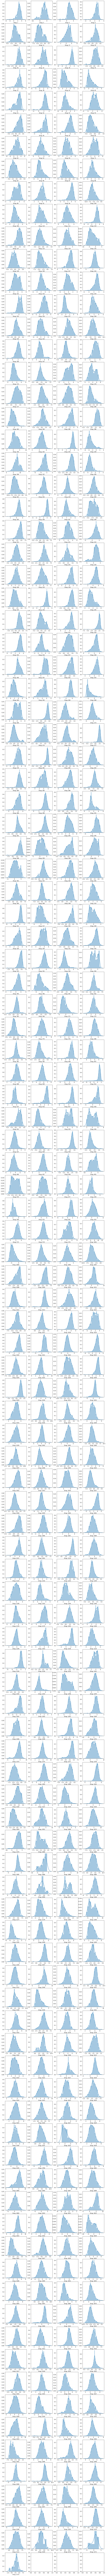

In [39]:
fig, ax = plt.subplots((ic50['Drug Id'].unique().size - 1) // 4 + 1,
                       4,
                       figsize=(15, 4 * 100))
count = 0
for drug_id in ic50['Drug Id'].unique():
    drug_id_ic50 = ic50[ic50['Drug Id'] == drug_id]['IC50'].values
    sns.distplot(drug_id_ic50, ax=ax[count // 4, count % 4], label=drug_id)
    ax[count // 4, count % 4].set_xlabel(f"Drug: {drug_id}")
    count += 1
plt.show()

## IC50 to filter drugs

In [126]:
ic50['sensitive'] = ic50['IC50'] < ic50['Max conc']

In [127]:
tmp = ic50.groupby(['Drug Id']).size().reset_index(name='cell_line_count')

In [128]:
ic50_sensitive_merge = pd.merge(
    ic50.groupby(['Drug Id']).size().reset_index(name='cell_line_count'),
    ic50.groupby(['Drug Id'
                  ])['sensitive'].sum().reset_index(name='sensitive_count'))
ic50_sensitive_merge['sensitive_ratio'] = ic50_sensitive_merge[
    'sensitive_count'] / ic50_sensitive_merge['cell_line_count']

In [138]:
ic50_sensitive_merge[ic50_sensitive_merge['sensitive_ratio'] < 0.1]

Drug Id  cell_line_count  sensitive_count  sensitive_ratio
17        52              397             28.0         0.070529
47       150              878              6.0         0.006834
60       166              887             88.0         0.099211
85       202              877             48.0         0.054732
131      277              920             39.0         0.042391
188      408              925             54.0         0.058378
214      562              915             56.0         0.061202
310     1200              764             12.0         0.015707
326     1262              909              7.0         0.007701
327     1263              894             29.0         0.032438
328     1264              908             22.0         0.024229
358     1576              727             23.0         0.031637
374     1627              727             23.0         0.031637
383     1802              728             16.0         0.021978
398     1830              728             30.0         0.041209
414     1915              760             53.0         0.069737
429     1936              751             58.0         0.077230

In [137]:
fig = px.scatter(ic50_sensitive_merge,
                 x="cell_line_count",
                 y="sensitive_ratio",
                 hover_name='Drug Id')
fig.show()

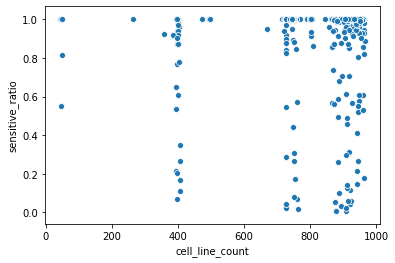

In [135]:
sns.scatterplot(x='cell_line_count',
                y='sensitive_ratio',
                data=ic50_sensitive_merge)

# RNA data

In [62]:
name_map = pd.read_csv("../data/misc/HUMAN_9606_idmapping.gene_prot.dat", sep='\t', names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code')

In [63]:
name_map_dict = dict(zip(name_map['Gene_Name'].values, name_map['UniProtKB-ID'].values))

In [78]:
rna_raw = pd.read_csv("../data/rnaseq_voom.csv", index_col=0).T

rna_raw.index.name='SIDM'

rna_raw = rna_raw.reset_index()

In [65]:
'H4C2' in rna_raw

False

In [80]:
rna_sample = pd.merge(rna_raw,
                      meta[['SIDM',
                            'Cell_line']].drop_duplicates()).drop(['SIDM'],
                                                                  axis=1)

In [81]:
corr_dict = {}
gene_not_found = []
for gene in rna_sample.drop(['Cell_line'], axis=1).columns:
    if gene not in name_map_dict:
        gene_not_found.append(gene)
        continue
    protein = name_map_dict[gene]
    if protein in protein_sample_avg.columns:
        data = pd.merge(protein_sample_avg[['Cell_line', protein]],
                        rna_sample[['Cell_line', gene]])
        data = data.dropna()
        corr_dict[gene] = spearmanr(data.iloc[:, 1], data.iloc[:, 2])[0]

In [83]:
np.median(list(corr_dict.values()))

0.35875015668757915

Text(-0.35667339099583056, 200, 'Median: 0.3588')

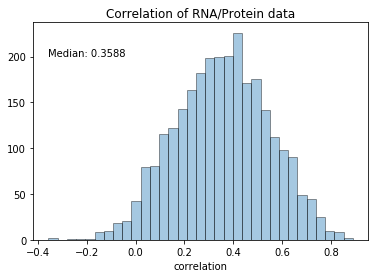

In [84]:
sns.distplot(list(corr_dict.values()),
             kde=False,
             hist_kws=dict(edgecolor="k", linewidth=1))
plt.title("Correlation of RNA/Protein data")
plt.xlabel("correlation")
plt.text(np.min(list(corr_dict.values())), 200,
         f"Median: {np.median(list(corr_dict.values())):.4f}")

# Missing value analysis

In [12]:
protein_raw_merge.head()

Automatic_MS_filename  1433B_HUMAN  1433E_HUMAN  1433F_HUMAN  \
0  180822_e0022_p02_2049_1_s_m04_1     0.504516     0.610363     0.023150   
1  180822_e0022_p02_2049_2_s_m04_1     2.383333     1.883481     0.376526   
2  180822_e0022_p02_2049_3_s_m04_1     0.216622     0.452995    -0.433584   
3  180822_e0022_p02_2495_1_s_m04_1    -0.268934    -0.577642    -0.150878   
4  180822_e0022_p02_2495_2_s_m04_1     0.568253    -0.090144    -0.167033   

   1433G_HUMAN  1433S_HUMAN  1433T_HUMAN  1433Z_HUMAN  1A03_HUMAN  1A24_HUMAN  \
0    -0.991845    -2.531949     1.020990     0.223633         NaN         NaN   
1    -0.288463    -1.909680     2.142906     1.460440         NaN         NaN   
2    -0.823484    -1.909680     0.994526     0.323496         NaN         NaN   
3    -0.652070          NaN    -0.909926    -0.779495         NaN         NaN   
4    -0.387978          NaN    -0.636183    -0.253842         NaN         NaN   

   ...  ZN768_HUMAN  ZNF22_HUMAN  ZNT9_HUMAN  ZO1_HUMAN  ZO2_HUMAN  \
0  ...          NaN     0.580027   -0.731266  -0.675204  -2.100365   
1  ...          NaN     0.242210   -0.636570  -0.675204  -1.912363   
2  ...          NaN     0.526368   -0.634359  -0.417358  -2.047511   
3  ...          NaN     0.194240         NaN        NaN  -1.387011   
4  ...          NaN     0.194240         NaN        NaN  -0.736023   

   ZPR1_HUMAN  ZRAB2_HUMAN  ZW10_HUMAN  ZYX_HUMAN  Cell_line  
0   -0.428590    -0.122452    0.009640        NaN  RPMI-8402  
1   -0.184543     0.233586    0.302442        NaN  RPMI-8402  
2   -0.306044     0.167848   -0.187573        NaN  RPMI-8402  
3   -0.502137    -0.812927   -0.057731   0.702576      NKM-1  
4   -0.245484    -0.981265   -0.064856   0.944272      NKM-1  

[5 rows x 3946 columns]

In [413]:
protein_raw_merge[protein_raw_merge['Cell_line']=='MOLM-13']

Automatic_MS_filename  1433B_HUMAN  1433E_HUMAN  1433F_HUMAN  \
2490  190524_5510_007zv_00bgq_m04_s_1     2.210665     0.331107          NaN   
2571  190529_5510_007zv_00bl5_m03_s_1     1.801575     0.474112          NaN   

      1433G_HUMAN  1433S_HUMAN  1433T_HUMAN  1433Z_HUMAN  1A03_HUMAN  \
2490     0.826131          NaN     0.299770     1.118062         NaN   
2571     0.334114          NaN    -0.123843     0.896705         NaN   

      1A24_HUMAN  ...  ZN768_HUMAN  ZNF22_HUMAN  ZNT9_HUMAN  ZO1_HUMAN  \
2490         NaN  ...          NaN          NaN         NaN        NaN   
2571         NaN  ...          NaN          NaN         NaN   1.186379   

      ZO2_HUMAN  ZPR1_HUMAN  ZRAB2_HUMAN  ZW10_HUMAN  ZYX_HUMAN  Cell_line  
2490        NaN         NaN     0.712556    1.330421   2.208880    MOLM-13  
2571  -0.803029         NaN     1.021906    1.217314   2.035053    MOLM-13  

[2 rows x 3946 columns]

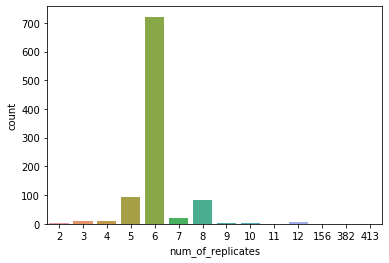

In [417]:
sns.countplot(
    protein_raw_merge.groupby([
        'Cell_line'
    ]).size().reset_index(name='num_of_replicates')['num_of_replicates'])

In [13]:
protein_raw_merge_rep_num = protein_raw_merge.groupby(
    ['Cell_line']).size().reset_index(name='num_of_replicates')

In [14]:
protein_raw_merge_six_rep = protein_raw_merge[
    protein_raw_merge['Cell_line'].isin(protein_raw_merge_rep_num[
        protein_raw_merge_rep_num['num_of_replicates'] == 6]['Cell_line'])]

In [424]:
protein_na_count = protein_raw_merge_six_rep.groupby(['Cell_line']).agg(lambda x:np.sum(np.isnan(x)))

In [425]:
protein_na_count = protein_na_count.astype(int)

In [15]:
# protein_na_count.to_csv("../data/protein_na_count.csv")
protein_na_count = pd.read_csv("../data/protein_na_count.csv")

In [16]:
protein_na_count_melt = pd.melt(protein_na_count.reset_index(),
                                id_vars='Cell_line',
                                value_name='na_count',
                                var_name='protein')

In [17]:
protein_raw_merge_melt = pd.melt(
    protein_raw_merge,
    id_vars=['Automatic_MS_filename', 'Cell_line'],
    value_name='expression',
    var_name='protein')

In [18]:
protein_raw_merge_melt_na_count = pd.merge(
    protein_raw_merge_melt,
    protein_na_count_melt,
    on=['Cell_line', 'protein']).dropna()

In [430]:
tmp = pd.merge(protein_raw_merge_melt,
               protein_na_count_melt[protein_na_count_melt['na_count'] == 5],
               on=['Cell_line', 'protein']).dropna()

In [19]:
all_protein_exp = protein_raw.drop(['Automatic_MS_filename'], axis=1).values.flatten()
all_protein_exp = all_protein_exp[~np.isnan(all_protein_exp)]

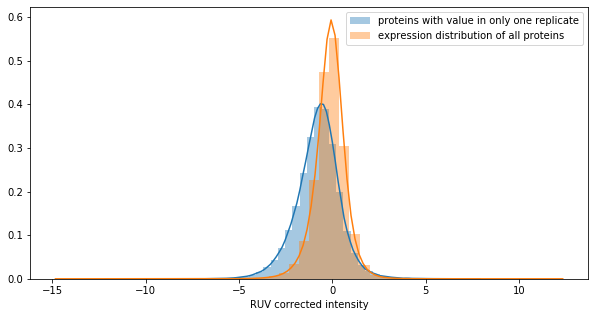

In [444]:
plt.figure(figsize=(10,5))
sns.distplot(tmp['expression'], label='proteins with value in only one replicate')
sns.distplot(all_protein_exp, label='expression distribution of all proteins')

plt.legend()
plt.xlabel("RUV corrected intensity")
plt.show()

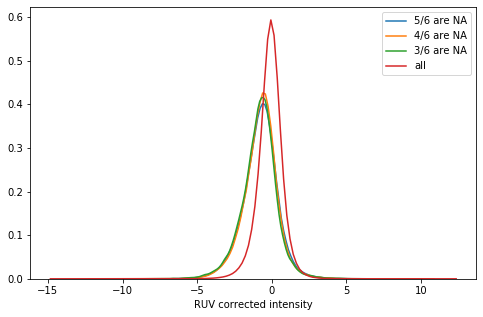

In [25]:
plt.figure(figsize=(8, 5))
sns.distplot(protein_raw_merge_melt_na_count[
    protein_raw_merge_melt_na_count['na_count'] == 5]['expression'],
             label='5/6 are NA',
             hist=False)
sns.distplot(protein_raw_merge_melt_na_count[
    protein_raw_merge_melt_na_count['na_count'] == 4]['expression'],
             label='4/6 are NA',
             hist=False)
sns.distplot(protein_raw_merge_melt_na_count[
    protein_raw_merge_melt_na_count['na_count'] == 3]['expression'],
             label='3/6 are NA',
             hist=False)
sns.distplot(all_protein_exp, label='all', hist=False)

plt.legend()
plt.xlabel("RUV corrected intensity")
plt.show()

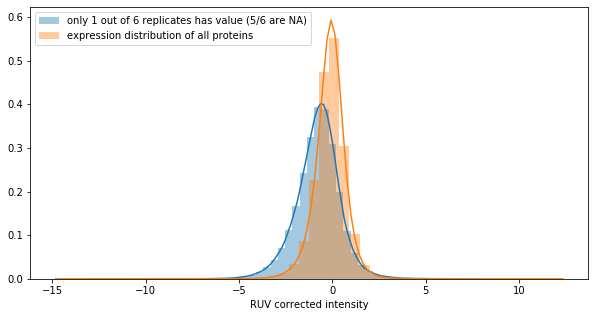

In [30]:
plt.figure(figsize=(10, 5))
sns.distplot(protein_raw_merge_melt_na_count[
    protein_raw_merge_melt_na_count['na_count'] == 5]['expression'],
             label='only 1 out of 6 replicates has value (5/6 are NA)')
sns.distplot(all_protein_exp,
             label='expression distribution of all proteins')

plt.legend()
plt.xlabel("RUV corrected intensity")
plt.show()

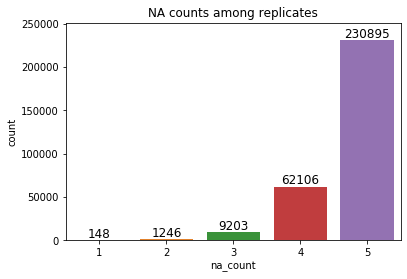

In [469]:
def roundup(x):
    return 20000 + int(math.ceil(x / 100.0)) * 100


df = protein_na_count_melt[(protein_na_count_melt['na_count'] > 0)
                           & (protein_na_count_melt['na_count'] < 6)]

sns.countplot(df['na_count'])

# Get current axis on current figure
ax = plt.gca()

# ylim max value to be set
y_max = df['na_count'].value_counts().max()
ax.set_ylim([0, roundup(y_max)])

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2.,
            p.get_height(),
            '%d' % int(p.get_height()),
            fontsize=12,
            color='black',
            ha='center',
            va='bottom')
plt.title("NA counts among replicates")
plt.show()

In [459]:
protein_na_count_melt.groupby(['na_count']).size()

na_count
0    2173824
1        148
2       1246
3       9203
4      62106
5     230895
6     366202
dtype: int64